<a href="https://colab.research.google.com/github/Many98/real_estate/blob/models/notebooks/XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

zkusit bez gp, price/m^2

In [131]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot
from matplotlib.pyplot import figure
from xgboost import plot_importance

#GET DATA & BASIC ANALYSIS

In [132]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('test_dataset.csv', sep=',', delimiter=None, encoding="utf8")
df_analysis = pd.read_csv('dataset.csv', sep=',', delimiter=None, encoding="utf8")
# drop indexes
df.drop(columns=df.columns[0], axis=1, inplace=True) 
df.describe()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (367,385,388,389,391,392) have mixed types.Specify dtype option on import or set low_memory=False.



,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní/obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1+kk,disposition_1+1,disposition_3+1,disposition_3+kk,disposition_2+kk,disposition_4+1,disposition_2+1,disposition_5+kk,disposition_4+kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5+1,disposition_6+kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_<1950,year_reconstruction_1951-1980,year_reconstruction_1981-2000,year_reconstruction_2001-2010,year_reconstruction_2011-2015,year_reconstruction_2016-2020,year_reconstruction_2021-2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1.0,air_quality_2.0,air_quality_3.0,air_quality_4.0,air_quality_5.0,built_density_unknown,built_density_1.0,built_density_2.0,built_density_3.0,built_density_4.0,built_density_5.0,sun_glare_unknown,sun_glare_1.0,sun_glare_2.0,sun_glare_3.0,sun_glare_4.0,sun_glare_5.0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist_>=1500m,bus_station_dist_0-99m,bus_station_dist_100-199m,bus_station_dist_200-299m,bus_station_dist_300-399m,bus_station_dist_400-499m,bus_station_dist_500-599m,bus_station_dist_600-699m,bus_station_dist_700-799m,bus_station_dist_800-899m,bus_station_dist_900-999m,bus_station_dist_1000-1099m,bus_station_dist_1100-1199m,bus_station_dist_1200-1299m,bus_station_dist_1300-1399m,bus_station_dist_1400-1499m,train_station_dist_>=1500m,train_station_dist_0-99m,train_station_dist_100-199m,train_station_dist_200-299m,train_station_dist_300-399m,train_station_dist_400-499m,train_station_dist_500-599m,train_station_dist_600-699m,train_station_dist_700-799m,train_station_dist_800-899m,train_station_dist_900-999m,train_station_dist_1000-1099m,train_station_dist_1100-1199m,train_station_dist_1200-1299m,train_station_dist_1300-1399m,train_station_dist_1400-1499m,subway_station_dist_>=1500m,subway_station_dist_0-99m,subway_station_dist_100-199m,subway_station_dist_200-299m,subway_station_dist_300-399m,subway_station_dist_400-499m,subway_station_dist_500-599m,subway_station_dist_600-699m,subway_station_dist_700-799m,subway_station_dist_800-899m,subway_station_dist_900-999m,subway_station_dist_1000-1099m,subway_station_dist_1100-1199m,subway_station_dist_1200-1299m,subway_station_dist_1300-1399m,subway_station_dist_1400-1499m,tram_station_dist_>=1500m,tram_station_dist_0-99m,tram_station_dist_100-199m,tram_station_dist_200-299m,tram_station_dist_300-399m,tram_station_dist_400-499m,tram_station_dist_500-599m,tram_station_dist_600-699m,tram_station_dist_700-799m,tram_station_dist_800-899m,tram_station_dist_900-999m,tram_station_dist_1000-1099m,tram_station_dist_1100-1199m,tram_station_dist_1200-1299m,tram_station_dist_1300-1399m,tram_station_dist_1400-1499m,post_office_dist_>=1500m,post_office_dist_0-99m,post_office_dist_100-199m,post_office_dist_200-299m,post_office_dist_300-399m,post_office_dist_400-499m,post_office_dist_500-599m,post_office_dist_600-699m,post_office_dist_700-799m,post_office_dist_800-899m,post_office_dist_900-999m,post_office_dist_1000-1099m,post_office_dist_1100-1199m,post_office_dist_1200-1299m,post_office_dist_1300-1399m,post_office_dist_1400-1499m,atm_dist_

In [133]:
# drop non-usable columns
df.drop("floor_area", axis=1, inplace=True) 
df.drop("desc_hash", axis=1, inplace=True) 
df.drop("hash", axis=1, inplace=True) 
# drop texts columns
df.drop("description", axis=1, inplace=True) # from nlp
df.drop("note", axis=1, inplace=True) # from nlp
df.drop("header", axis=1, inplace=True) # from nlp
df.drop("heating_txt", axis=1, inplace=True)
df.drop("waste_txt", axis=1, inplace=True)
df.drop("telecomunication_txt", axis=1, inplace=True)
df.drop("electricity_txt", axis=1, inplace=True)
df.drop("tags", axis=1, inplace=True)
df.drop("geometry", axis=1, inplace=True)
df.drop("additional_disposition", axis=1, inplace=True) 
df.drop("transport", axis=1, inplace=True) 
df.drop("name", axis=1, inplace=True) 
df.drop("place", axis=1, inplace=True) # praha 1 apod.
df.drop("date", axis=1, inplace=True) # later transform into float (2018+2/12)

In [134]:
# for error feature_names may not contain [, ] or <
df.columns = df.columns.str.replace(r'.', '_')
df.columns = df.columns.str.replace(r'-', '_')
df.columns = df.columns.str.replace(r'>=', '_vetsi_rovno_')
df.columns = df.columns.str.replace(r'+', '_plus_')
df.columns = df.columns.str.replace(r' ', '_')
df.columns = df.columns.str.replace(r'/', '_')
df.columns = df.columns.str.replace(r'[', '_')
df.columns = df.columns.str.replace(r']', '_')
df.columns = df.columns.str.replace(r'<', 'mensi')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular

In [135]:
# columns with embeddings
only_embeddings = [i for i in df.columns if 'emb' in i]
df = df.drop([emb for emb in only_embeddings], axis=1)
# only ordinal columns 
only_ord = [i for i in df.columns if 'ord' in i]

# columns with ordinal distance
only_ord_dist = [i for i in df.columns if 'dist' in i and 'ord' in i and 'num' not in i and 'city' not in i]
# only numerical dist columns (with indicator >=1500m)
only_num_dist = [i for i in df.columns if 'dist' in i and 'ord' not in i and 'num' in i and 'city' not in i] + \
                [i for i in df.columns if '1500m' in i]
# only one-hot encoded distances
only_one_hot_dist = [i for i in df.columns if 'dist' in i and 'ord' not in i and
                     'num' not in i and 'city' not in i]
only_one_hot_100m = [i for i in df.columns if '0-99m' in i]
# only coordinates
only_coords = ['long', 'lat']
# Gaussian process predicition
only_gp = [i for i in df.columns if 'gp' in i]
# noise
only_noise = [i for i in df.columns if 'noise' in i]
# quality
only_quality_ord = [i for i in df.columns if ('quality' in i or
                'sun' in i or 'built' in i) and 'ord' in i]
# one hotncoded energy effeciency
only_energy = [i for i in df.columns if 'energy_effeciency' in i and 'ord' not in i]
# disposition
only_disposition = [i for i in df.columns if 'disposition' in i]
# construction_type
only_construction = [i for i in df.columns if 'construction_t' in i]
# ownership
only_ownership = [i for i in df.columns if 'ownership' in i]
# equipment
only_equipment = [i for i in df.columns if 'equipment' in i]
# state
only_state = [i for i in df.columns if 'state' in i]
# only has_<> features
only_has = [i for i in df.columns if 'has' in i]

In [136]:
# e.g. when u want columns without embeddings and without ordinal features and without
#one-hot encoded ditances do something like that
df1 = df[df.columns.difference(only_embeddings + only_ord + only_one_hot_dist)]

In [137]:
df.head()

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní_obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1_plus_kk,disposition_1_plus_1,disposition_3_plus_1,disposition_3_plus_kk,disposition_2_plus_kk,disposition_4_plus_1,disposition_2_plus_1,disposition_5_plus_kk,disposition_4_plus_kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5_plus_1,disposition_6_plus_kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_mensi1950,year_reconstruction_1951_1980,year_reconstruction_1981_2000,year_reconstruction_2001_2010,year_reconstruction_2011_2015,year_reconstruction_2016_2020,year_reconstruction_2021_2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1_0,air_quality_2_0,air_quality_3_0,air_quality_4_0,air_quality_5_0,built_density_unknown,built_density_1_0,built_density_2_0,built_density_3_0,built_density_4_0,built_density_5_0,sun_glare_unknown,sun_glare_1_0,sun_glare_2_0,sun_glare_3_0,sun_glare_4_0,sun_glare_5_0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist__vetsi_rovno_1500m,bus_station_dist_0_99m,bus_station_dist_100_199m,bus_station_dist_200_299m,bus_station_dist_300_399m,bus_station_dist_400_499m,bus_station_dist_500_599m,bus_station_dist_600_699m,bus_station_dist_700_799m,bus_station_dist_800_899m,bus_station_dist_900_999m,bus_station_dist_1000_1099m,bus_station_dist_1100_1199m,bus_station_dist_1200_1299m,bus_station_dist_1300_1399m,bus_station_dist_1400_1499m,train_station_dist__vetsi_rovno_1500m,train_station_dist_0_99m,train_station_dist_100_199m,train_station_dist_200_299m,train_station_dist_300_399m,train_station_dist_400_499m,train_station_dist_500_599m,train_station_dist_600_699m,train_station_dist_700_799m,train_station_dist_800_899m,train_station_dist_900_999m,train_station_dist_1000_1099m,train_station_dist_1100_1199m,train_station_dist_1200_1299m,train_station_dist_1300_1399m,train_station_dist_1400_1499m,subway_station_dist__vetsi_rovno_1500m,subway_station_dist_0_99m,subway_station_dist_100_199m,subway_station_dist_200_299m,subway_station_dist_300_399m,subway_station_dist_400_499m,subway_station_dist_500_599m,subway_station_dist_600_699m,subway_station_dist_700_799m,subway_station_dist_800_899m,subway_station_dist_900_999m,subway_station_dist_1000_1099m,subway_station_dist_1100_1199m,subway_station_dist_1200_1299m,subway_station_dist_1300_1399m,subway_station_dist_1400_1499m,tram_station_dist__vetsi_rovno_1500m,tram_station_dist_0_99m,tram_station_dist_100_199m,tram_station_dist_200_299m,tram_station_dist_300_399m,tram_station_dist_400_499m,tram_station_dist_500_599m,tram_station_dist_600_699m,tram_station_dist_700_799m,tram_station_dist_800_899m,tram_station_dist_900_999m,tram_station_dist_1000_1099m,tram_station_dist_1100_1199m,tram_station_dist_1200_1299m,tram_station_dist_1300_1399m,tram_station_dist_1400_1499m,post_office_dist__vetsi_rovno_1500m,post_office_dist_0_99m,post_office_dist_100_199m,post_office_dist_200_299m,post_office_dist_300_399m,post_office_dist_400_499m,post_office_dist_500_599m,post_office_dist_600_699m,post_office_dist_700_799m,post_office_dist_800_899m,post_office_dist_900_999m,post_office_dist_1000_1099m,post_of

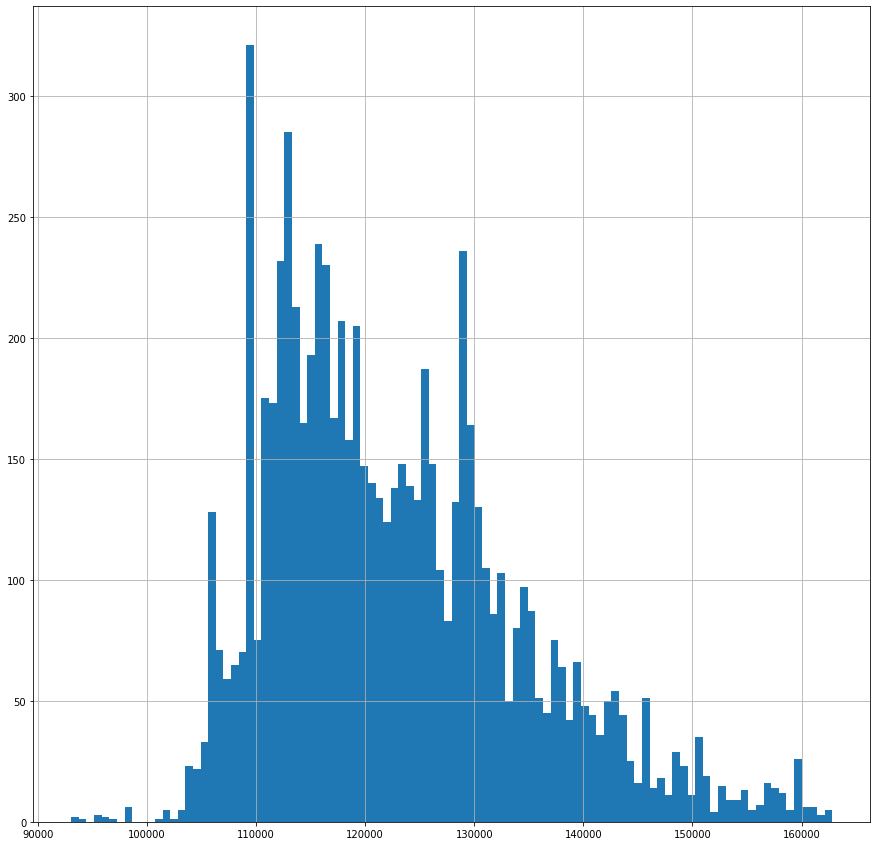

In [138]:
hist = df["gp_mean_price"].hist(bins=100)

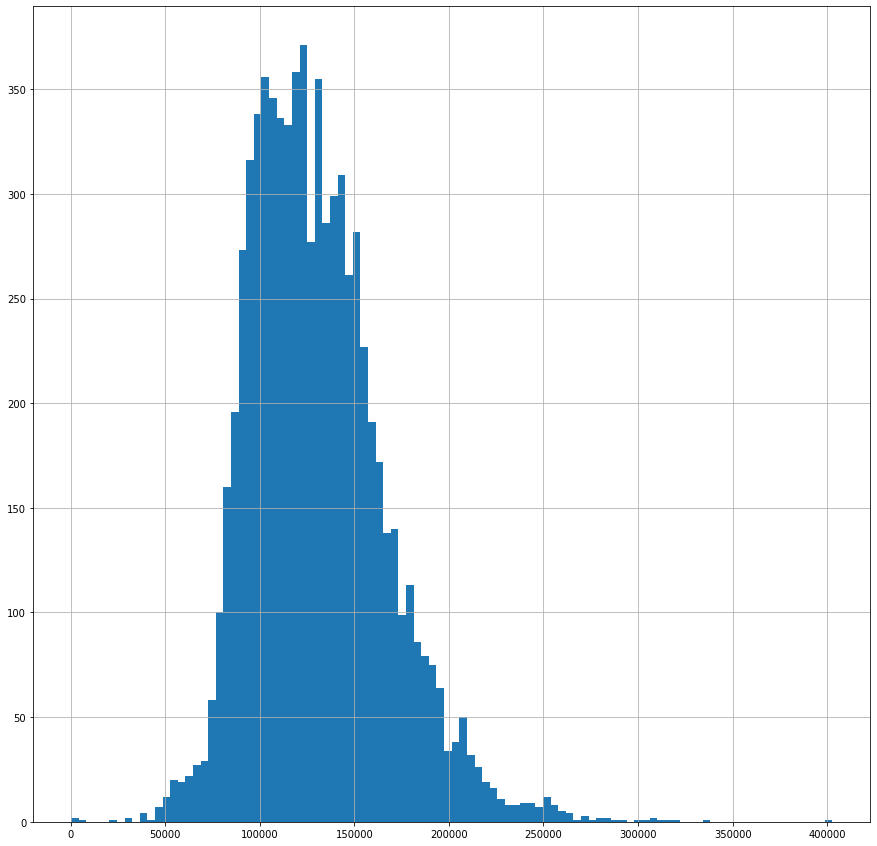

In [139]:
df['price_m2'] = df["price"]/df["usable_area"]
hist = df["price_m2"].hist(bins=100)

In [140]:
fig = px.box(df, y="gp_mean_price")
fig.show()

In [141]:
fig = px.box(df, y="price_m2")
fig.show()

In [142]:
df[df.price_m2 < 30000] # byty za 25000 a 23000 jenom? - Prodej podílu 1/345 bytu 3+kk 57 m² - inzerát: https://www.sreality.cz/hledani/prodej/byty/praha?cena-od=0&cena-do=25000

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní_obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1_plus_kk,disposition_1_plus_1,disposition_3_plus_1,disposition_3_plus_kk,disposition_2_plus_kk,disposition_4_plus_1,disposition_2_plus_1,disposition_5_plus_kk,disposition_4_plus_kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5_plus_1,disposition_6_plus_kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_mensi1950,year_reconstruction_1951_1980,year_reconstruction_1981_2000,year_reconstruction_2001_2010,year_reconstruction_2011_2015,year_reconstruction_2016_2020,year_reconstruction_2021_2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1_0,air_quality_2_0,air_quality_3_0,air_quality_4_0,air_quality_5_0,built_density_unknown,built_density_1_0,built_density_2_0,built_density_3_0,built_density_4_0,built_density_5_0,sun_glare_unknown,sun_glare_1_0,sun_glare_2_0,sun_glare_3_0,sun_glare_4_0,sun_glare_5_0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist__vetsi_rovno_1500m,bus_station_dist_0_99m,bus_station_dist_100_199m,bus_station_dist_200_299m,bus_station_dist_300_399m,bus_station_dist_400_499m,bus_station_dist_500_599m,bus_station_dist_600_699m,bus_station_dist_700_799m,bus_station_dist_800_899m,bus_station_dist_900_999m,bus_station_dist_1000_1099m,bus_station_dist_1100_1199m,bus_station_dist_1200_1299m,bus_station_dist_1300_1399m,bus_station_dist_1400_1499m,train_station_dist__vetsi_rovno_1500m,train_station_dist_0_99m,train_station_dist_100_199m,train_station_dist_200_299m,train_station_dist_300_399m,train_station_dist_400_499m,train_station_dist_500_599m,train_station_dist_600_699m,train_station_dist_700_799m,train_station_dist_800_899m,train_station_dist_900_999m,train_station_dist_1000_1099m,train_station_dist_1100_1199m,train_station_dist_1200_1299m,train_station_dist_1300_1399m,train_station_dist_1400_1499m,subway_station_dist__vetsi_rovno_1500m,subway_station_dist_0_99m,subway_station_dist_100_199m,subway_station_dist_200_299m,subway_station_dist_300_399m,subway_station_dist_400_499m,subway_station_dist_500_599m,subway_station_dist_600_699m,subway_station_dist_700_799m,subway_station_dist_800_899m,subway_station_dist_900_999m,subway_station_dist_1000_1099m,subway_station_dist_1100_1199m,subway_station_dist_1200_1299m,subway_station_dist_1300_1399m,subway_station_dist_1400_1499m,tram_station_dist__vetsi_rovno_1500m,tram_station_dist_0_99m,tram_station_dist_100_199m,tram_station_dist_200_299m,tram_station_dist_300_399m,tram_station_dist_400_499m,tram_station_dist_500_599m,tram_station_dist_600_699m,tram_station_dist_700_799m,tram_station_dist_800_899m,tram_station_dist_900_999m,tram_station_dist_1000_1099m,tram_station_dist_1100_1199m,tram_station_dist_1200_1299m,tram_station_dist_1300_1399m,tram_station_dist_1400_1499m,post_office_dist__vetsi_rovno_1500m,post_office_dist_0_99m,post_office_dist_100_199m,post_office_dist_200_299m,post_office_dist_300_399m,post_office_dist_400_499m,post_office_dist_500_599m,post_office_dist_600_699m,post_office_dist_700_799m,post_office_dist_800_899m,post_office_dist_900_999m,post_office_dist_1000_1099m,post_of

In [143]:
df[df.price_m2 > 400000] # https://www.sreality.cz/detail/prodej/byt/2+kk/praha-vysocany-podebradska/4035192396 - chyba v inzerátu

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní_obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1_plus_kk,disposition_1_plus_1,disposition_3_plus_1,disposition_3_plus_kk,disposition_2_plus_kk,disposition_4_plus_1,disposition_2_plus_1,disposition_5_plus_kk,disposition_4_plus_kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5_plus_1,disposition_6_plus_kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_mensi1950,year_reconstruction_1951_1980,year_reconstruction_1981_2000,year_reconstruction_2001_2010,year_reconstruction_2011_2015,year_reconstruction_2016_2020,year_reconstruction_2021_2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1_0,air_quality_2_0,air_quality_3_0,air_quality_4_0,air_quality_5_0,built_density_unknown,built_density_1_0,built_density_2_0,built_density_3_0,built_density_4_0,built_density_5_0,sun_glare_unknown,sun_glare_1_0,sun_glare_2_0,sun_glare_3_0,sun_glare_4_0,sun_glare_5_0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist__vetsi_rovno_1500m,bus_station_dist_0_99m,bus_station_dist_100_199m,bus_station_dist_200_299m,bus_station_dist_300_399m,bus_station_dist_400_499m,bus_station_dist_500_599m,bus_station_dist_600_699m,bus_station_dist_700_799m,bus_station_dist_800_899m,bus_station_dist_900_999m,bus_station_dist_1000_1099m,bus_station_dist_1100_1199m,bus_station_dist_1200_1299m,bus_station_dist_1300_1399m,bus_station_dist_1400_1499m,train_station_dist__vetsi_rovno_1500m,train_station_dist_0_99m,train_station_dist_100_199m,train_station_dist_200_299m,train_station_dist_300_399m,train_station_dist_400_499m,train_station_dist_500_599m,train_station_dist_600_699m,train_station_dist_700_799m,train_station_dist_800_899m,train_station_dist_900_999m,train_station_dist_1000_1099m,train_station_dist_1100_1199m,train_station_dist_1200_1299m,train_station_dist_1300_1399m,train_station_dist_1400_1499m,subway_station_dist__vetsi_rovno_1500m,subway_station_dist_0_99m,subway_station_dist_100_199m,subway_station_dist_200_299m,subway_station_dist_300_399m,subway_station_dist_400_499m,subway_station_dist_500_599m,subway_station_dist_600_699m,subway_station_dist_700_799m,subway_station_dist_800_899m,subway_station_dist_900_999m,subway_station_dist_1000_1099m,subway_station_dist_1100_1199m,subway_station_dist_1200_1299m,subway_station_dist_1300_1399m,subway_station_dist_1400_1499m,tram_station_dist__vetsi_rovno_1500m,tram_station_dist_0_99m,tram_station_dist_100_199m,tram_station_dist_200_299m,tram_station_dist_300_399m,tram_station_dist_400_499m,tram_station_dist_500_599m,tram_station_dist_600_699m,tram_station_dist_700_799m,tram_station_dist_800_899m,tram_station_dist_900_999m,tram_station_dist_1000_1099m,tram_station_dist_1100_1199m,tram_station_dist_1200_1299m,tram_station_dist_1300_1399m,tram_station_dist_1400_1499m,post_office_dist__vetsi_rovno_1500m,post_office_dist_0_99m,post_office_dist_100_199m,post_office_dist_200_299m,post_office_dist_300_399m,post_office_dist_400_499m,post_office_dist_500_599m,post_office_dist_600_699m,post_office_dist_700_799m,post_office_dist_800_899m,post_office_dist_900_999m,post_office_dist_1000_1099m,post_of

In [144]:
# keep flats > 35 000/m^2 and < 350 000/m^2
df = df[df.price_m2 > 40000]
df = df[df.price_m2 < 350000]

In [145]:
fig = px.box(df, y="price_m2")
fig.show()

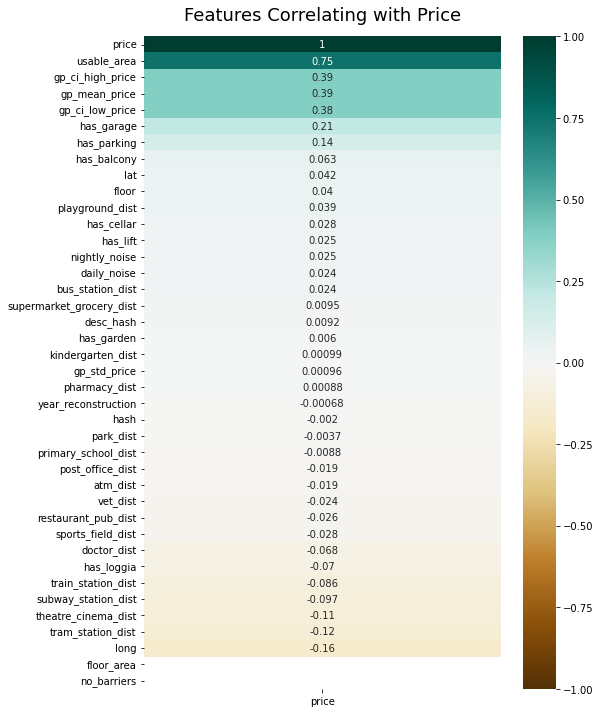

In [146]:
df_analysis.corr()[['price']].sort_values(by='price', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_analysis.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':18}, pad=16);

In [147]:
df.drop("price_m2", axis=1, inplace=True)

In [148]:
df.head()

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní_obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1_plus_kk,disposition_1_plus_1,disposition_3_plus_1,disposition_3_plus_kk,disposition_2_plus_kk,disposition_4_plus_1,disposition_2_plus_1,disposition_5_plus_kk,disposition_4_plus_kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5_plus_1,disposition_6_plus_kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_mensi1950,year_reconstruction_1951_1980,year_reconstruction_1981_2000,year_reconstruction_2001_2010,year_reconstruction_2011_2015,year_reconstruction_2016_2020,year_reconstruction_2021_2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1_0,air_quality_2_0,air_quality_3_0,air_quality_4_0,air_quality_5_0,built_density_unknown,built_density_1_0,built_density_2_0,built_density_3_0,built_density_4_0,built_density_5_0,sun_glare_unknown,sun_glare_1_0,sun_glare_2_0,sun_glare_3_0,sun_glare_4_0,sun_glare_5_0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist__vetsi_rovno_1500m,bus_station_dist_0_99m,bus_station_dist_100_199m,bus_station_dist_200_299m,bus_station_dist_300_399m,bus_station_dist_400_499m,bus_station_dist_500_599m,bus_station_dist_600_699m,bus_station_dist_700_799m,bus_station_dist_800_899m,bus_station_dist_900_999m,bus_station_dist_1000_1099m,bus_station_dist_1100_1199m,bus_station_dist_1200_1299m,bus_station_dist_1300_1399m,bus_station_dist_1400_1499m,train_station_dist__vetsi_rovno_1500m,train_station_dist_0_99m,train_station_dist_100_199m,train_station_dist_200_299m,train_station_dist_300_399m,train_station_dist_400_499m,train_station_dist_500_599m,train_station_dist_600_699m,train_station_dist_700_799m,train_station_dist_800_899m,train_station_dist_900_999m,train_station_dist_1000_1099m,train_station_dist_1100_1199m,train_station_dist_1200_1299m,train_station_dist_1300_1399m,train_station_dist_1400_1499m,subway_station_dist__vetsi_rovno_1500m,subway_station_dist_0_99m,subway_station_dist_100_199m,subway_station_dist_200_299m,subway_station_dist_300_399m,subway_station_dist_400_499m,subway_station_dist_500_599m,subway_station_dist_600_699m,subway_station_dist_700_799m,subway_station_dist_800_899m,subway_station_dist_900_999m,subway_station_dist_1000_1099m,subway_station_dist_1100_1199m,subway_station_dist_1200_1299m,subway_station_dist_1300_1399m,subway_station_dist_1400_1499m,tram_station_dist__vetsi_rovno_1500m,tram_station_dist_0_99m,tram_station_dist_100_199m,tram_station_dist_200_299m,tram_station_dist_300_399m,tram_station_dist_400_499m,tram_station_dist_500_599m,tram_station_dist_600_699m,tram_station_dist_700_799m,tram_station_dist_800_899m,tram_station_dist_900_999m,tram_station_dist_1000_1099m,tram_station_dist_1100_1199m,tram_station_dist_1200_1299m,tram_station_dist_1300_1399m,tram_station_dist_1400_1499m,post_office_dist__vetsi_rovno_1500m,post_office_dist_0_99m,post_office_dist_100_199m,post_office_dist_200_299m,post_office_dist_300_399m,post_office_dist_400_499m,post_office_dist_500_599m,post_office_dist_600_699m,post_office_dist_700_799m,post_office_dist_800_899m,post_office_dist_900_999m,post_office_dist_1000_1099m,post_of

#XGBoost

MODEL WITH ALL PARAMETRES

In [149]:
Y = df['price'].values.reshape(-1,1)
X = df.drop("price", axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [150]:
duplicate_columns = X.columns[X.columns.duplicated()]
duplicate_columns

Index([], dtype='object')

In [151]:
basic_model = XGBRegressor()
basic_model.fit(X_train, Y_train)
y_pred = basic_model.predict(X_test)
predictions = [round(value) for value in y_pred]
print("The model training score is " , basic_model.score(X_train, Y_train))
print("The model testing score is " , basic_model.score(X_test, Y_test)) # 2500 pozorování
print("The model testing mean absolute error is ", mean_absolute_error(Y_test, y_pred))
print("The model max error is ", max_error(Y_test, y_pred))
print("The model median absolute error is ", median_absolute_error(Y_test, y_pred))

[12:51:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The model training score is  0.9027396862294992
The model testing score is  0.8283836467621052
The model testing mean absolute error is  1274429.1703020134
The model max error is  39078388.0
The model median absolute error is  729479.0


In [152]:
basic_model = XGBRegressor(n_estimators = 1000,
                        boosting_type='dart',
                        learning_rate=0.09, 
                        colsample_bytree=0.96,
                        colsample_bynode=1,
                        #objective='reg:squarederror',
                        #eval_metric=mean_absolute_error,
                        max_depth=3,
                        #tree_method='hist',
                        #enable_categorical=True,
                        #subsample=0.9,
                        random_state=42, silent=True, 
                        #booster='gbtree',
                     
            early_stopping_rounds=20)
basic_model.fit(X_train, Y_train)
y_pred = basic_model.predict(X_test)
predictions = [round(value) for value in y_pred]
print("The model training score is " , basic_model.score(X_train, Y_train))
print("The model testing score is " , basic_model.score(X_test, Y_test)) # 2500 pozorování
print("The model testing mean absolute error is ", mean_absolute_error(Y_test, y_pred))
print("The model max error is ", max_error(Y_test, y_pred))
print("The model median absolute error is ", median_absolute_error(Y_test, y_pred))

The model training score is  0.9721946458776044
The model testing score is  0.8435742294782553
The model testing mean absolute error is  1171923.5784395973
The model max error is  35910172.0
The model median absolute error is  672890.25


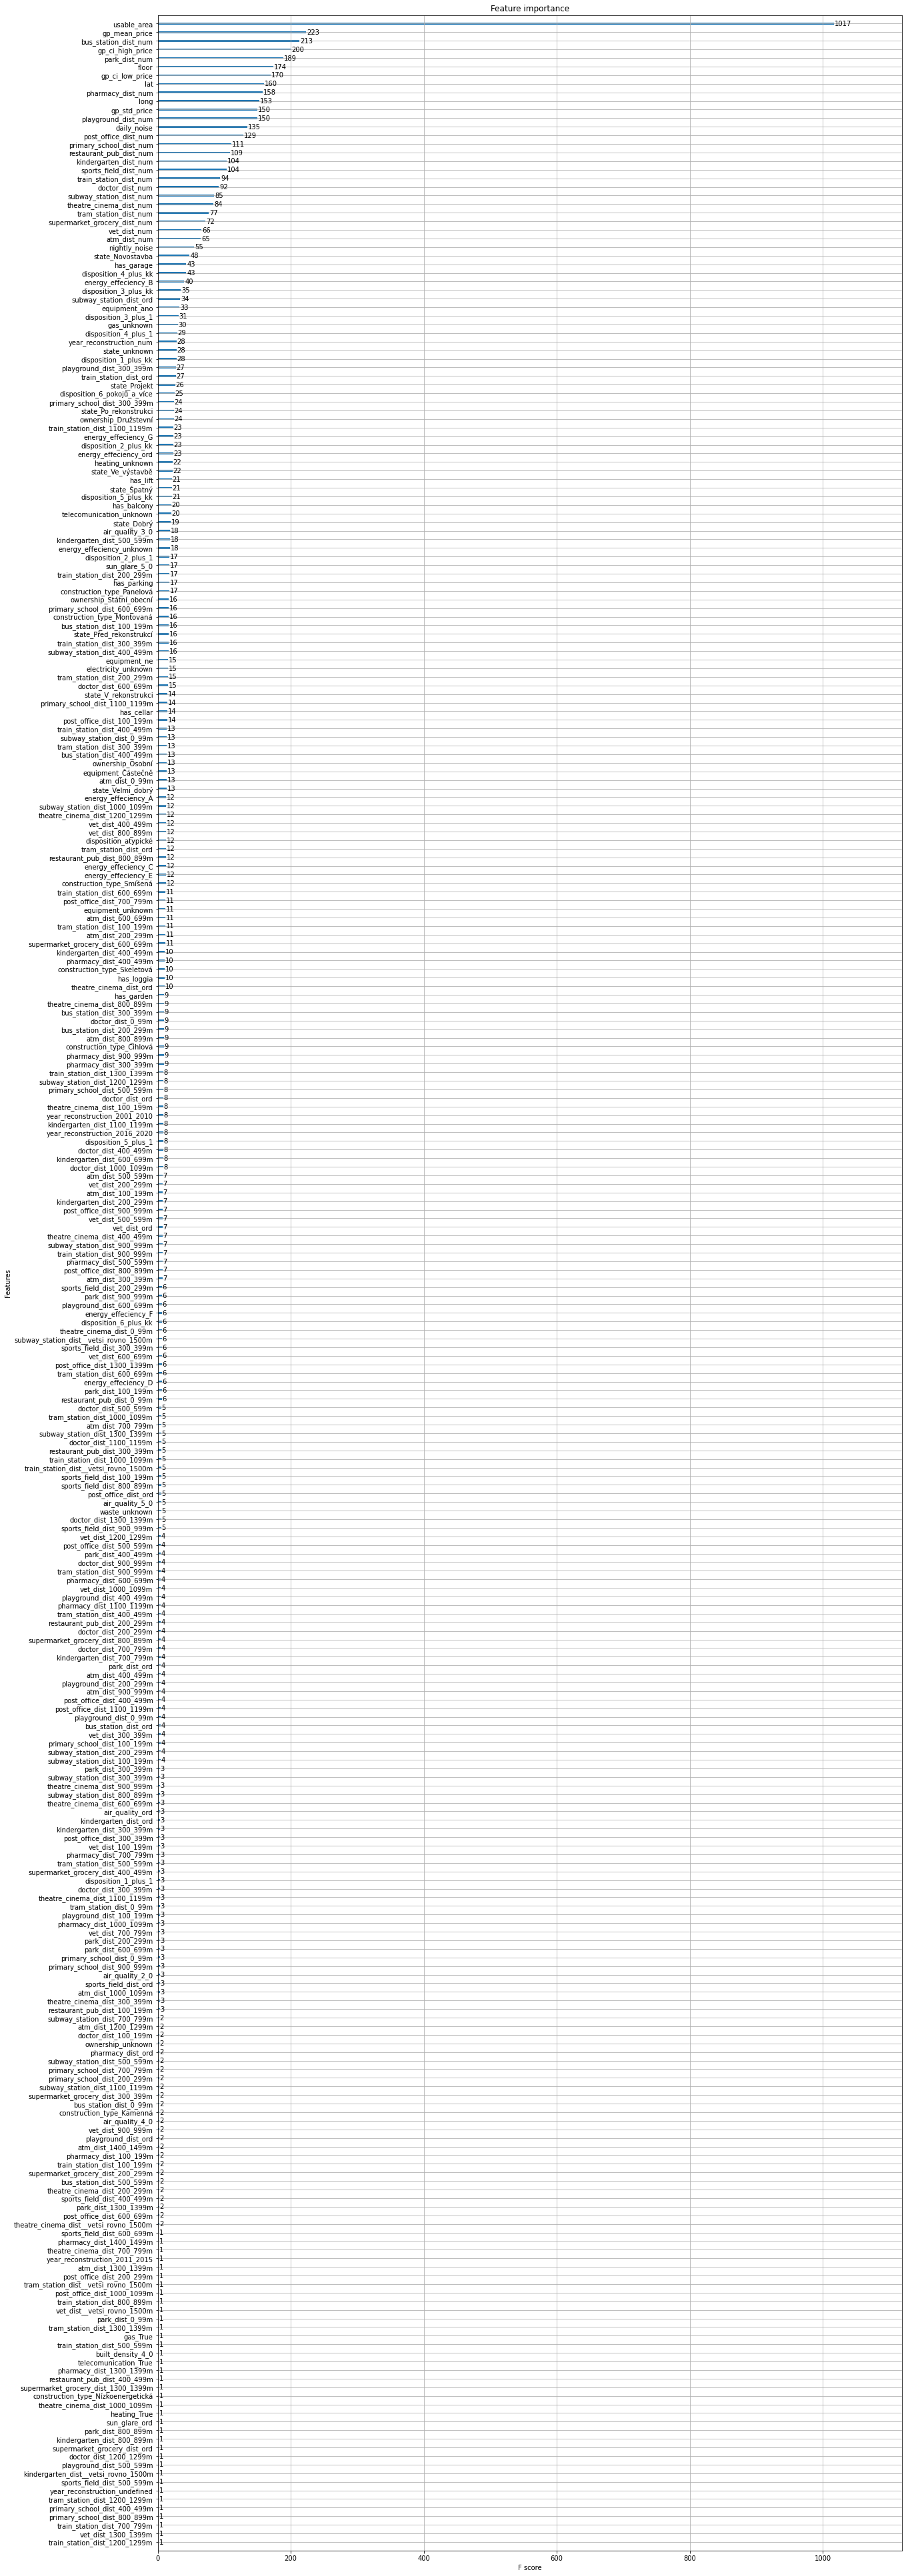

In [153]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
ax = plot_importance(basic_model)
fig = ax.figure
fig.set_size_inches(20,70)
fig.show()

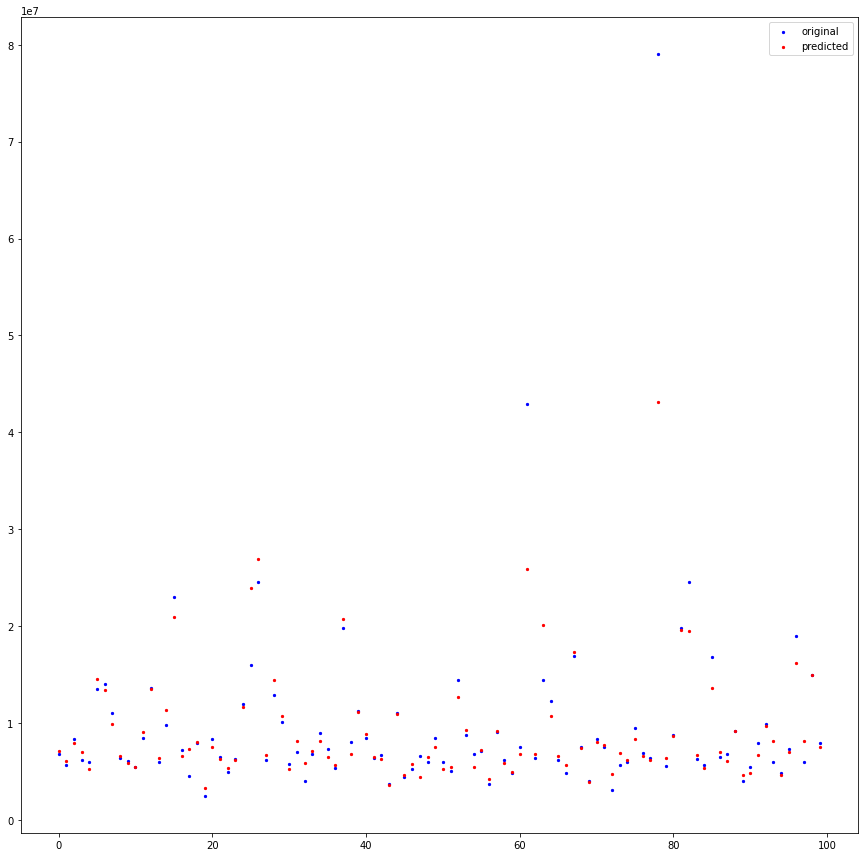

In [154]:
# x_ax = range(len(Y_test))
x_ax = range(100)
plt.rcParams["figure.figsize"] = (15, 15)
plt.scatter(x_ax, Y_test[:100], s=5, color="blue", label="original")
plt.scatter(x_ax, y_pred[:100], s=5, color="red", label="predicted")
plt.legend()
plt.show()

In [155]:
# https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html
y_pred = basic_model.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 4649842818631.40
RMSE: 2156349.42


In [156]:
'''kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, xtrain, ytrain, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())'''

'kfold = KFold(n_splits=10, shuffle=True)\nkf_cv_scores = cross_val_score(xgbr, xtrain, ytrain, cv=kfold )\nprint("K-fold CV average score: %.2f" % kf_cv_scores.mean())'

MODEL with m^2 almost the same as with the price

MODEL with numerical distance

In [157]:
Y_num = df['price'].values.reshape(-1,1)
X_num = df.drop("price", axis=1)
X_num = X_num.drop([ord for ord in only_ord_dist], axis=1)
X_num = X_num.drop([hot for hot in only_one_hot_dist], axis=1)
X_train_num, X_test_num, Y_train_num, Y_test_num = train_test_split(X_num, Y_num, test_size=0.2, random_state=42, shuffle=True)

In [158]:
numerical_model = XGBRegressor(n_estimators = 1000,
                        boosting_type='dart',
                        learning_rate=0.09, 
                        colsample_bytree=0.96,
                        colsample_bynode=1,
                        #objective='reg:squarederror',
                        #eval_metric=mean_absolute_error,
                        max_depth=3,
                        #tree_method='hist',
                        #enable_categorical=True,
                        #subsample=0.9,
                        random_state=42, silent=True, 
                        #booster='gbtree',
                     
            early_stopping_rounds=20)
numerical_model.fit(X_train_num, Y_train_num)
y_pred_num = numerical_model.predict(X_test_num)
predictions = [round(value) for value in y_pred_num]
print("The model training score is " , numerical_model.score(X_train_num, Y_train_num))
print("The model testing score is " , numerical_model.score(X_test_num, Y_test_num))
print("The model testing mean absolute error is ", mean_absolute_error(Y_test_num, y_pred_num))
print("The model max error is ", max_error(Y_test_num, y_pred_num))
print("The model median absolute error is ", median_absolute_error(Y_test_num, y_pred_num))

The model training score is  0.9709915991195249
The model testing score is  0.845158839100142
The model testing mean absolute error is  1168240.414261745
The model max error is  36412972.0
The model median absolute error is  668522.125


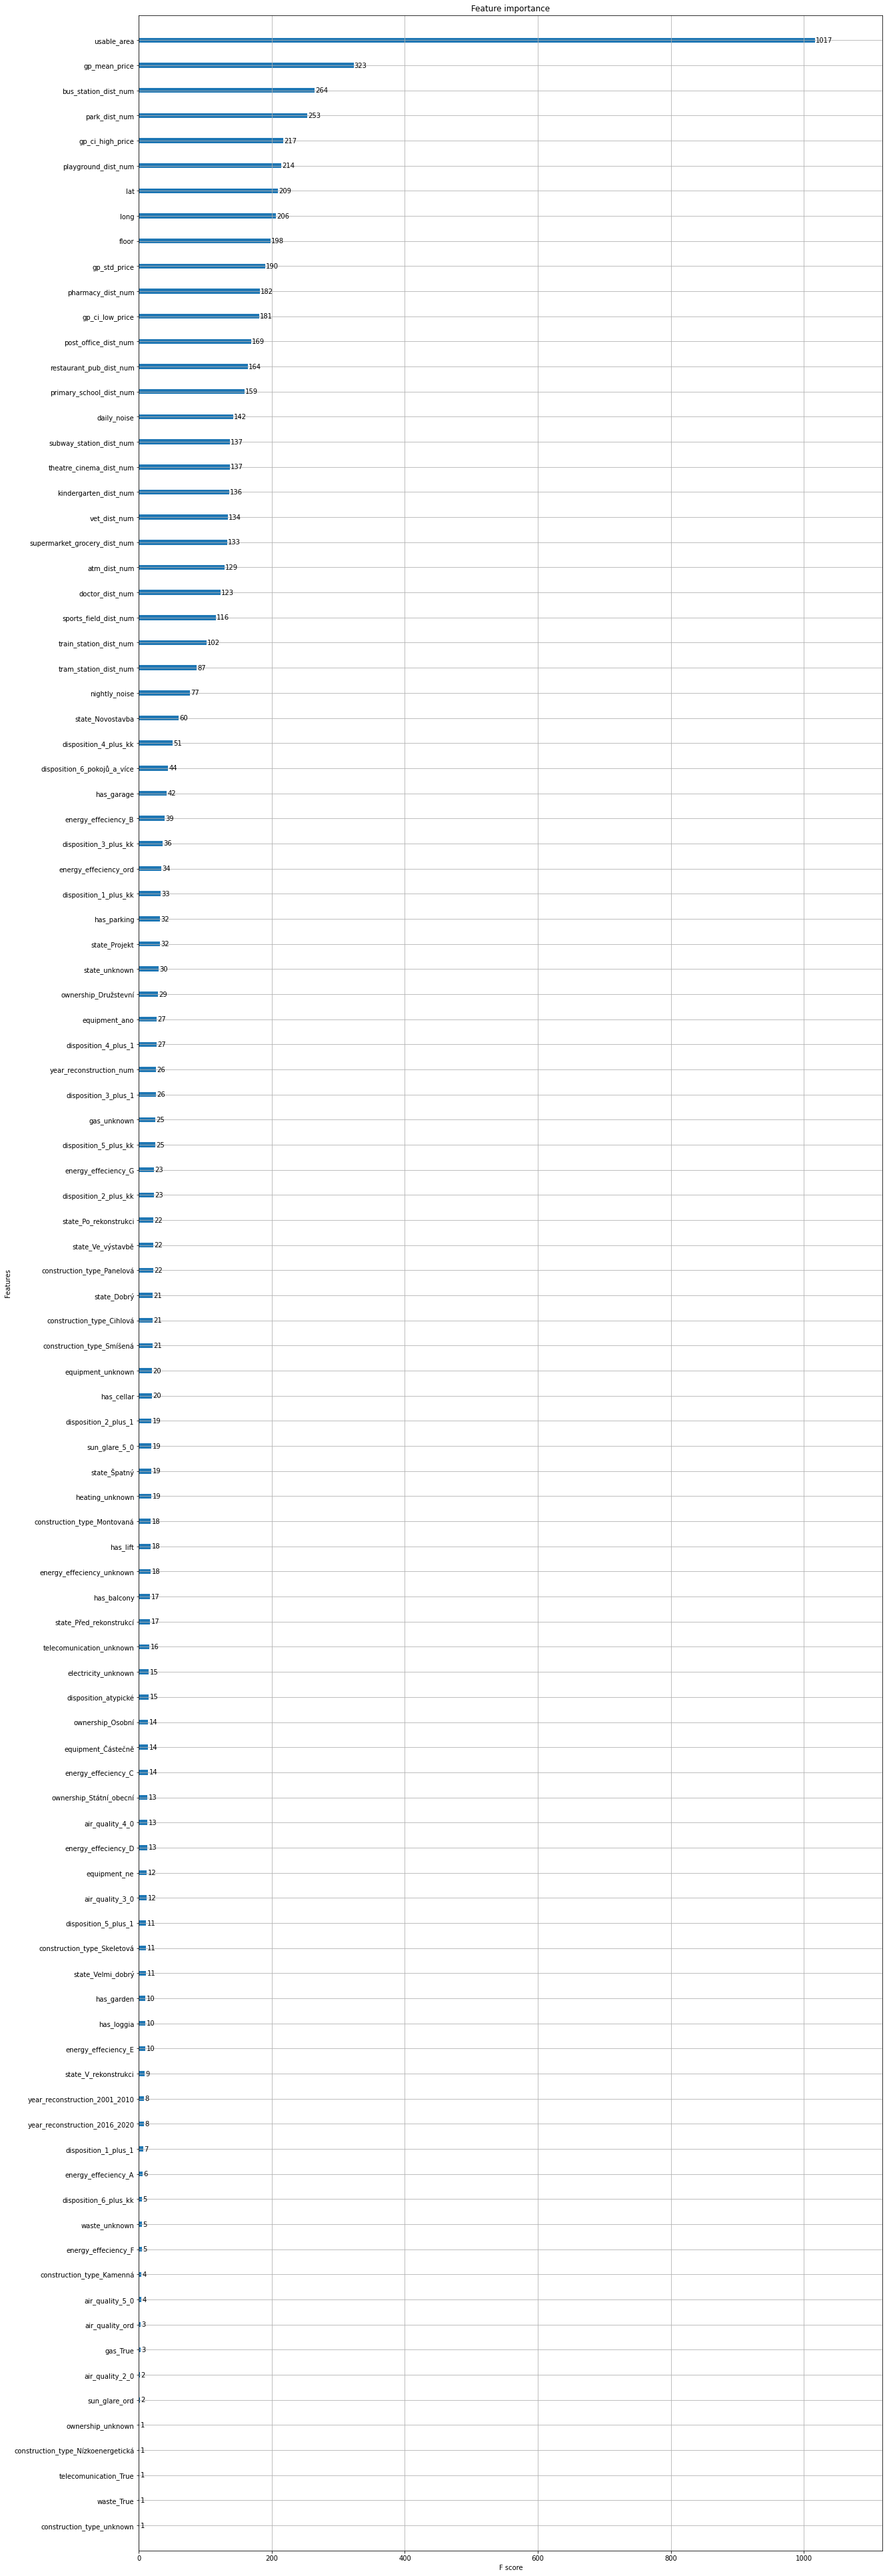

In [159]:
ax = plot_importance(numerical_model)
fig = ax.figure
fig.set_size_inches(20,70)
fig.show()

In [164]:
# try model without gp
Y_num_without_gp = df['price'].values.reshape(-1,1)
X_num_without_gp = df.drop("price", axis=1)
X_num_without_gp = X_num_without_gp.drop([ord for ord in only_ord_dist], axis=1)
X_num_without_gp = X_num_without_gp.drop([hot for hot in only_one_hot_dist], axis=1)
X_num_without_gp = X_num_without_gp.drop([gp for gp in only_gp], axis=1)
X_train_num_without_gp, X_test_num_without_gp, Y_train_num_without_gp, Y_test_num_without_gp = train_test_split(X_num_without_gp, Y_num_without_gp, test_size=0.2, random_state=42, shuffle=True)
numerical_model_without_gp = XGBRegressor(n_estimators = 1000,
                        boosting_type='dart',
                        learning_rate=0.09, 
                        colsample_bytree=0.96,
                        colsample_bynode=1,
                        #objective='reg:squarederror',
                        #eval_metric=mean_absolute_error,
                        max_depth=3,
                        #tree_method='hist',
                        #enable_categorical=True,
                        #subsample=0.9,
                        random_state=42, silent=True, 
                        #booster='gbtree',
                     
            early_stopping_rounds=20)
numerical_model_without_gp.fit(X_train_num_without_gp, Y_train_num_without_gp)
y_pred_num_without_gp = numerical_model_without_gp.predict(X_test_num_without_gp)
predictions = [round(value) for value in y_pred_num_without_gp]
print("The model training score is " , numerical_model.score(X_train_num_without_gp, Y_train_num_without_gp))
print("The model testing score is " , numerical_model.score(X_test_num_without_gp, Y_test_num_without_gp))
print("The model testing mean absolute error is ", mean_absolute_error(Y_test_num_without_gp, y_pred_num_without_gp))
print("The model max error is ", max_error(Y_test_num_without_gp, y_pred_num_without_gp))
print("The model median absolute error is ", median_absolute_error(Y_test_num_without_gp, y_pred_num_without_gp))

The model training score is  0.9678764583731541
The model testing score is  0.8432528427235397
The model testing mean absolute error is  1193423.2253355705
The model max error is  39287600.0
The model median absolute error is  696274.75


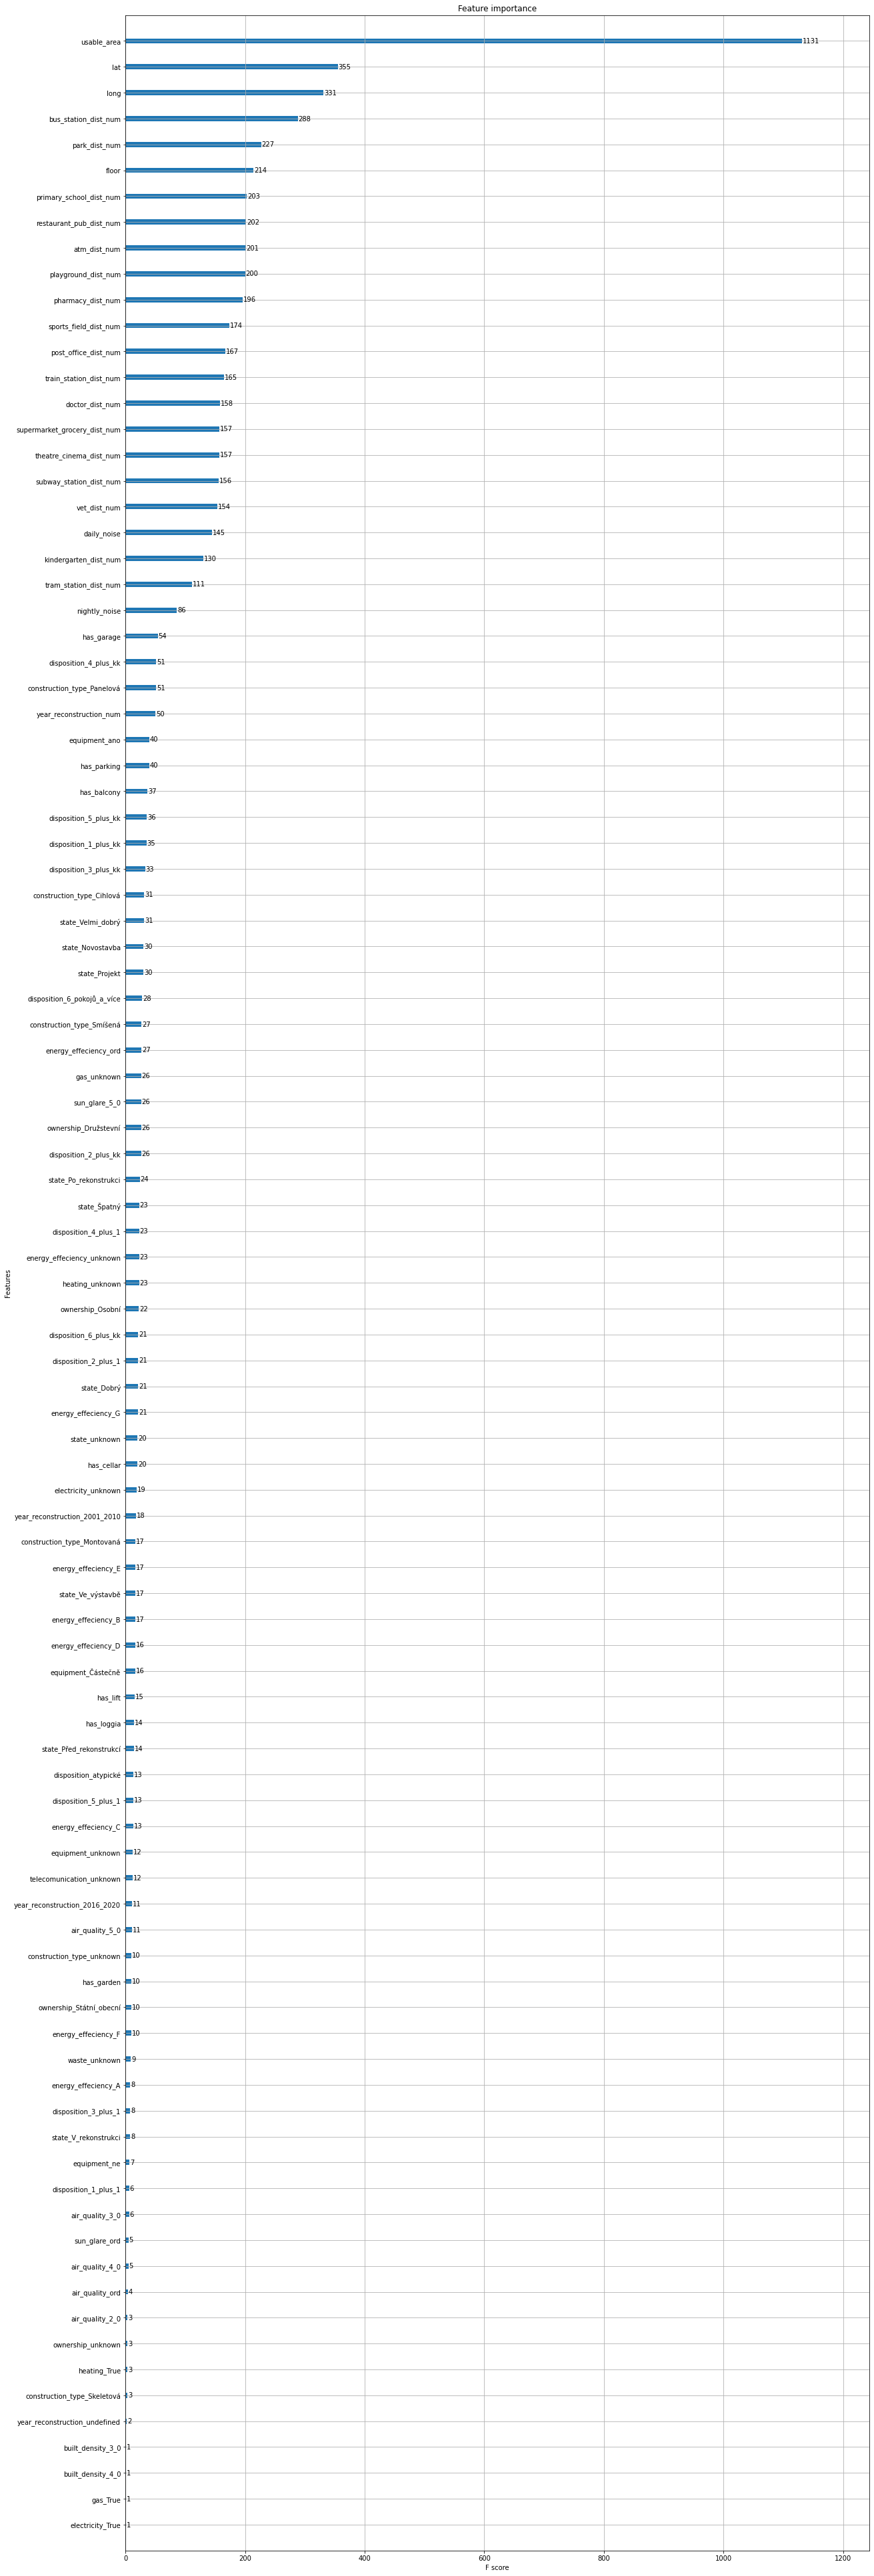

In [165]:
ax = plot_importance(numerical_model_without_gp)
fig = ax.figure
fig.set_size_inches(20,70)
fig.show()

In [179]:
X_test_num_without_gp['prediction'] = y_pred_num_without_gp
X_test_num_without_gp['true_label'] = Y_test_num
X_test_num_without_gp['error'] = abs(X_test_num_without_gp['true_label']) - abs(X_test_num_without_gp['prediction'])
X_test_num_without_gp['true_price_per_m2'] = X_test_num_without_gp['true_label']/X_test_num_without_gp['usable_area']
X_test_num_without_gp['predicted_price_per_m2'] = X_test_num_without_gp['prediction']/X_test_num_without_gp['usable_area']
X_test_num_without_gp['error_per_m2'] = abs(X_test_num_without_gp['true_price_per_m2']) - abs(X_test_num_without_gp['predicted_price_per_m2'])
# pro kladné = podceněné, pro záporné nadceněné
# podceněné byty o 750 000
# X_test_num_without_gp[X_test_num_without_gp.error > 750000] 
fig = px.box(X_test_num_without_gp, y="error_per_m2")
fig.show()

In [180]:
X_test_num_without_gp[X_test_num_without_gp.error_per_m2 > 45000]

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní_obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1_plus_kk,disposition_1_plus_1,disposition_3_plus_1,disposition_3_plus_kk,disposition_2_plus_kk,disposition_4_plus_1,disposition_2_plus_1,disposition_5_plus_kk,disposition_4_plus_kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5_plus_1,disposition_6_plus_kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_mensi1950,year_reconstruction_1951_1980,year_reconstruction_1981_2000,year_reconstruction_2001_2010,year_reconstruction_2011_2015,year_reconstruction_2016_2020,year_reconstruction_2021_2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1_0,air_quality_2_0,air_quality_3_0,air_quality_4_0,air_quality_5_0,built_density_unknown,built_density_1_0,built_density_2_0,built_density_3_0,built_density_4_0,built_density_5_0,sun_glare_unknown,sun_glare_1_0,sun_glare_2_0,sun_glare_3_0,sun_glare_4_0,sun_glare_5_0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,usable_area,floor,long,lat,has_lift,has_garage,has_cellar,no_barriers,has_loggia,has_balcony,has_garden,has_parking,bus_station_dist_num,train_station_dist_num,subway_station_dist_num,tram_station_dist_num,post_office_dist_num,atm_dist_num,doctor_dist_num,vet_dist_num,primary_school_dist_num,kindergarten_dist_num,supermarket_grocery_dist_num,restaurant_pub_dist_num,playground_dist_num,sports_field_dist_num,theatre_cinema_dist_num,pharmacy_dist_num,park_dist_num,year_reconstruction_num,year_reconstruction_ord,energy_effeciency_ord,air_quality_ord,built_density_ord,sun_glare_ord,prediction,true_label,error,true_price_per_m^2,predicted_price_per_m^2,error_per_m^2,true_price_per_m2,predicted_price_per_m2,error_per_m2
1145,55.0,50.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,31.0,7.0,14.468814,50.057550,True,True,True,True,True,False,False,False,242.000000,932.000000,1848.000000,79.000000,1077.000000,221.000000,1269.000000,620.000000,842.000000,228.000000,875.000000,1044.000000,49.000000,916.000000,1702.000000,238.000000,44.919073,0.0,0,0,5.0,5.0,5.0,4389290.50,6590000.0,2200709.50,212580.645161,141590.016129,70990.629032,212580.645161,141590.016129,70990.629032
2135,45.0,35.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,263.0,6.0,14.360925,50.062496,True,True,True,True,False,False,False,False,96.000000,245.000000,1146.000000,794.000000,1257.000000,1097.000000,631.000000,979.000000,844.000000,52.000000,942.000000,490.000000,186.000000,478.000000,1816.000000,1017.000000,568.015216,0.0,0,0,3.0,3.0,3.0,2785

MODEL with ordinal

MODEL with onehot - from importance features we can see, that onehot for distance aren't significant

MODEL with monotonic constrains

In [162]:
constraints = []
for i in range(421):
  constraints.append(0)
colNames = df.columns[df.columns.str.contains(pat = 'noise')]
print(colNames)
# give column name
col_name = "daily_noise"
# find the index no
index_no = df.columns.get_loc(col_name)
print(index_no)
col_name = "nightly_noise"
index_no = df.columns.get_loc(col_name)
print(index_no)
constraints[0] = -1
constraints[1] = -1

Index(['daily_noise', 'nightly_noise'], dtype='object')
0
1


In [163]:
'''params_constrained = params.copy()
params_constrained['monotone_constraints'] = constraints'''

"params_constrained = params.copy()\nparams_constrained['monotone_constraints'] = constraints"

MODEL with target-encoding

RANDOM SEARCH

GRID SEARCH

BAYES. SEARCH